#📄 **Loan Approval Dataset Description**
This dataset contains 4,269 records related to customer loan applications. It includes 13 features capturing demographic information, financial status, asset ownership, and loan details, along with the final loan approval status.


| Column                       | Description                                            |
| ---------------------------- | ------------------------------------------------------ |
| **loan_id**                  | Unique identifier for each loan application.           |
| **no_of_dependents**         | Number of dependents the applicant has.                |
| **education**                | Educational background (e.g., Graduate, Not Graduate). |
| **self_employed**            | Whether the applicant is self-employed (Yes/No).       |
| **income_annum**             | Applicant’s annual income.                             |
| **loan_amount**              | Total loan amount requested.                           |
| **loan_term**                | Duration of the loan in months.                        |
| **cibil_score**              | Applicant’s credit score.                              |
| **residential_assets_value** | Value of residential assets owned.                     |
| **commercial_assets_value**  | Value of commercial assets owned.                      |
| **luxury_assets_value**      | Value of luxury assets owned.                          |
| **bank_asset_value**         | Total value of bank-related assets.                    |
| **loan_status**              | Loan approval status (Approved/Rejected).              |


# **Importing Libraries and Reading Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/loan_approval_dataset.csv')

# **Data Inspection and Handling**

Before building the regression model on loan_amount, several preprocessing steps were applied to clean and refine the dataset:

1. Filtering Approved Loans

Since the goal is to predict the loan amount, only applications with an approved loan are relevant.
All rows where loan_status = "Rejected" were removed.

2. Removing the Target-Unrelated Column

After filtering the data, the loan_status column was dropped entirely because it is no longer needed for the regression task.

3. Preparing Features for Regression

With only approved loans remaining, the dataset is now focused on predicting loan_amount using the remaining financial, demographic, and asset-related features.

Outcome

The resulting dataset includes only approved loan applications and contains all the necessary predictors for building a clean and accurate regression model.

In [ ]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


# **Data Preprocessing**

**Dropping the 'loan_id' column becuase we don't need it**

In [ ]:
df.drop('loan_id', axis=1, inplace=True)

**Trimming the names of the columns to deal easily with them**

In [ ]:
df.columns = df.columns.str.strip()
print("Columns after stripping:", df.columns.tolist())

Columns after stripping: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


**Filtering the dataset to have only the *Approved* loans & Dropping the 'loan_status' column after**

In [ ]:
df['loan_status']=df['loan_status'].str.strip()
df = df.drop(df[df['loan_status'] == 'Rejected'].index)

In [ ]:
df.drop('loan_status', axis=1, inplace=True)

In [ ]:
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000
6,5,Graduate,No,8700000,33000000,4,678,22500000,14800000,29200000,4300000
8,0,Graduate,Yes,800000,2200000,20,782,1300000,800000,2800000,600000
10,4,Graduate,Yes,2900000,11200000,2,547,8100000,4700000,9500000,3100000
13,2,Graduate,Yes,9100000,31500000,14,679,10800000,16600000,20900000,5000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2656 entries, 0 to 4268
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          2656 non-null   int64 
 1   education                 2656 non-null   object
 2   self_employed             2656 non-null   object
 3   income_annum              2656 non-null   int64 
 4   loan_amount               2656 non-null   int64 
 5   loan_term                 2656 non-null   int64 
 6   cibil_score               2656 non-null   int64 
 7   residential_assets_value  2656 non-null   int64 
 8   commercial_assets_value   2656 non-null   int64 
 9   luxury_assets_value       2656 non-null   int64 
 10  bank_asset_value          2656 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 249.0+ KB


**Handling Outliers**

In [ ]:
def remove_outliers_iqr(hd, column):
    Q1 = hd[column].quantile(0.25)
    Q3 = hd[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    hd[column] = hd[column].clip(lower, upper)
    return hd
num_cols = ['no_of_dependents','income_annum','loan_amount','loan_term',
            'cibil_score','residential_assets_value',
            'commercial_assets_value','luxury_assets_value','bank_asset_value']
for col in num_cols:
    df = remove_outliers_iqr(df,col)

In [ ]:
from scipy import stats
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    outliers_mask = z_scores > threshold
    outliers_count = outliers_mask.sum()

    print(f"{column}:")
    print(f"  Outliers (Z-score > {threshold}): {outliers_count} ({outliers_count/len(data)*100:.2f}%)")
    if outliers_count > 0:
        print(f"  Max Z-score: {z_scores.max():.2f}")
    print()

numeric_cols = ['income_annum', 'loan_amount', 'cibil_score',
                'residential_assets_value', 'commercial_assets_value',
                'luxury_assets_value', 'bank_asset_value']

for col in numeric_cols:
    detect_outliers_zscore(df, col, threshold=3)

income_annum:
  Outliers (Z-score > 3): 0 (0.00%)

loan_amount:
  Outliers (Z-score > 3): 0 (0.00%)

cibil_score:
  Outliers (Z-score > 3): 0 (0.00%)

residential_assets_value:
  Outliers (Z-score > 3): 0 (0.00%)

commercial_assets_value:
  Outliers (Z-score > 3): 0 (0.00%)

luxury_assets_value:
  Outliers (Z-score > 3): 0 (0.00%)

bank_asset_value:
  Outliers (Z-score > 3): 0 (0.00%)



**Encoding the categorical columns**

In [ ]:
enc_education = LabelEncoder()
enc_self_employed = LabelEncoder()

df['education'] = enc_education.fit_transform(df['education'])
df['self_employed'] = enc_self_employed.fit_transform(df['self_employed'])

**Feature Extraction**

* **Creating 'total_assets' feature**

In [ ]:
df['total_assets'] = df['residential_assets_value'] + \
                     df['commercial_assets_value'] + \
                     df['luxury_assets_value'] + \
                     df['bank_asset_value']

print("DataFrame with 'total_assets' feature:")
display(df.head())

DataFrame with 'total_assets' feature:


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,total_assets
0,2,0,0,9600000,29900000,12,778.0,2400000,17400000,22700000,8000000,50500000
6,5,0,0,8700000,33000000,4,678.0,22500000,14800000,29200000,4300000,70800000
8,0,0,1,800000,2200000,20,782.0,1300000,800000,2800000,600000,5500000
10,4,0,1,2900000,11200000,2,547.0,8100000,4700000,9500000,3100000,25400000
13,2,0,1,9100000,31500000,14,679.0,10800000,16600000,20900000,5000000,53300000


In [ ]:
print("DataFrame head with 'total_assets':")
display(df[['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'total_assets']].head())

print("\nDescriptive statistics for 'total_assets':")
display(df['total_assets'].describe())

DataFrame head with 'total_assets':


,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,total_assets
0,2400000,17400000,22700000,8000000,50500000
6,22500000,14800000,29200000,4300000,70800000
8,1300000,800000,2800000,600000,5500000
10,8100000,4700000,9500000,3100000,25400000
13,10800000,16600000,20900000,5000000,53300000



Descriptive statistics for 'total_assets':


,total_assets
count,2.656000e+03
mean,3.235066e+07
std,1.958224e+07
min,7.000000e+05
25%,1.577500e+07
50%,3.100000e+07
75%,4.695000e+07
max,8.645000e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2656 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   no_of_dependents          2656 non-null   int64  
 1   education                 2656 non-null   int64  
 2   self_employed             2656 non-null   int64  
 3   income_annum              2656 non-null   int64  
 4   loan_amount               2656 non-null   int64  
 5   loan_term                 2656 non-null   int64  
 6   cibil_score               2656 non-null   float64
 7   residential_assets_value  2656 non-null   int64  
 8   commercial_assets_value   2656 non-null   int64  
 9   luxury_assets_value       2656 non-null   int64  
 10  bank_asset_value          2656 non-null   int64  
 11  total_assets              2656 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 269.8 KB


# **Data Visualization**

**Histogram & boxplot of every feature**

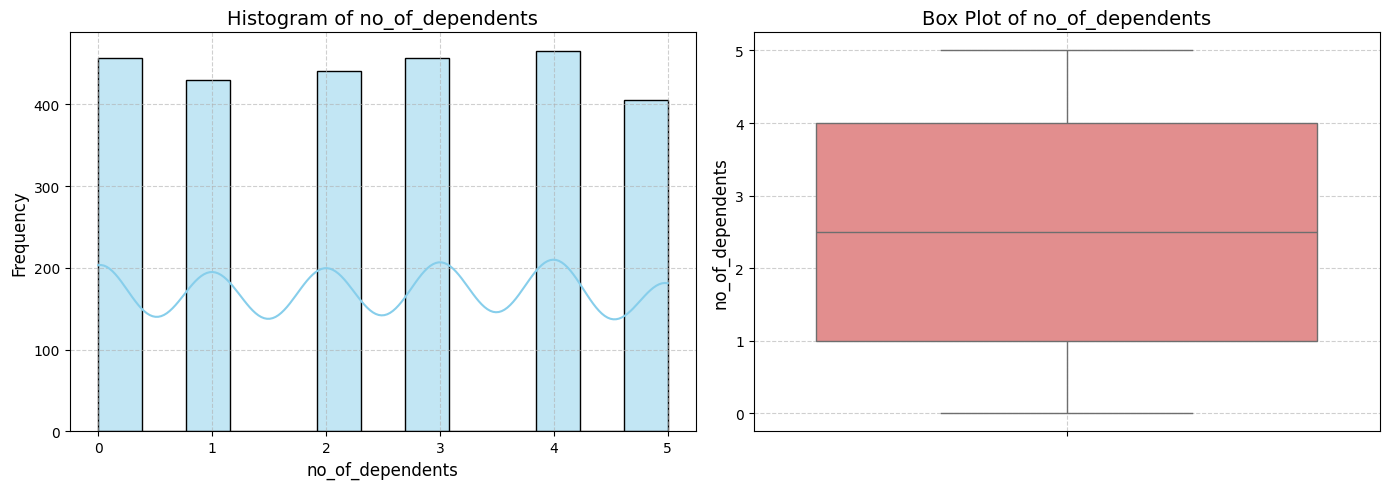

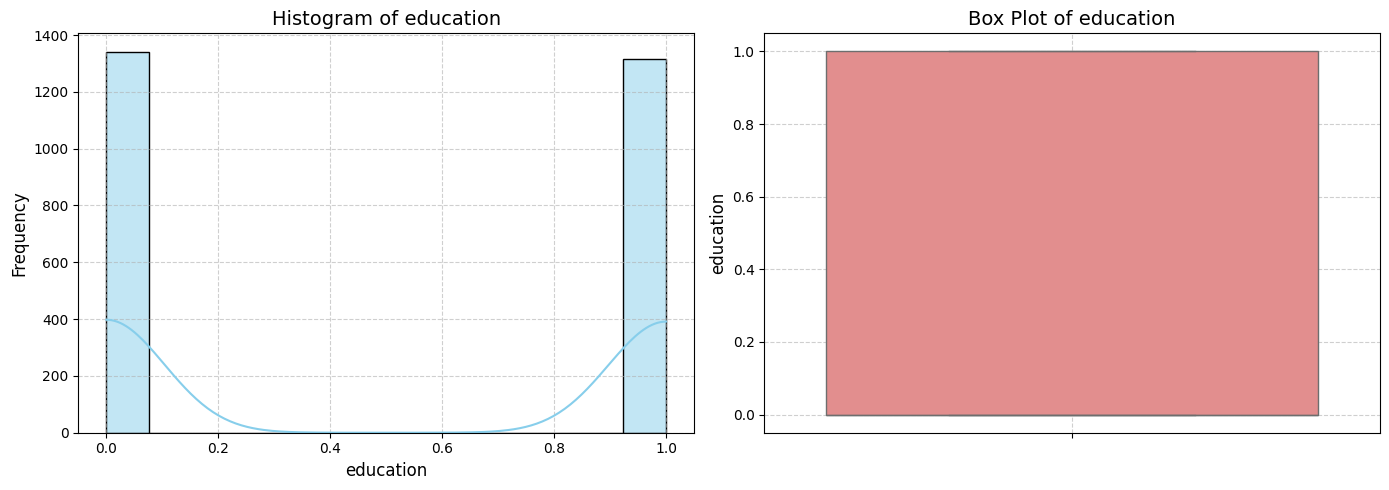

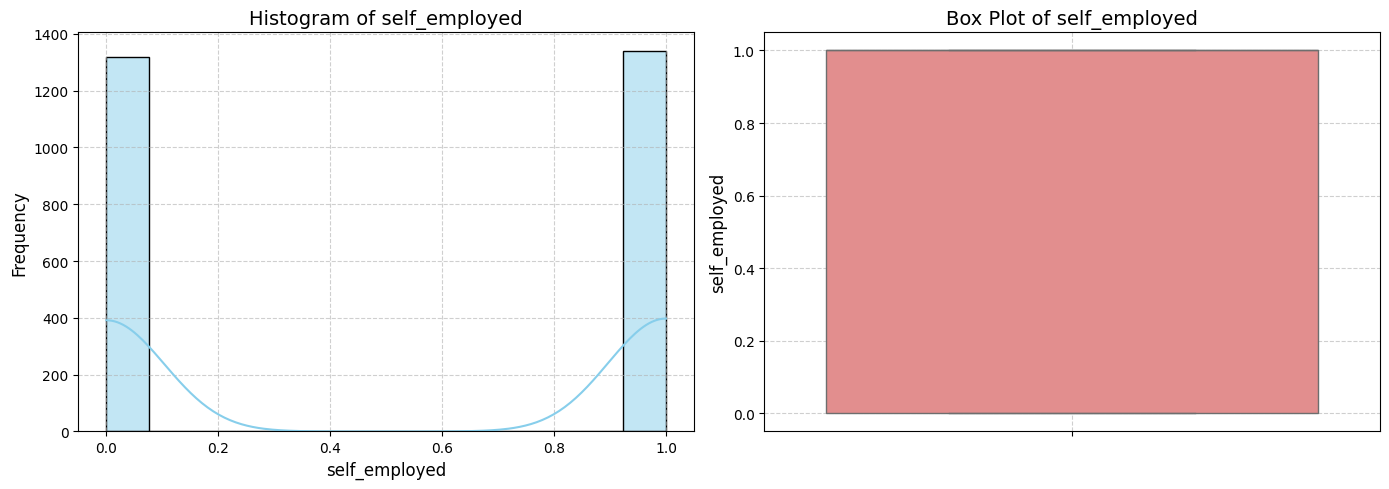

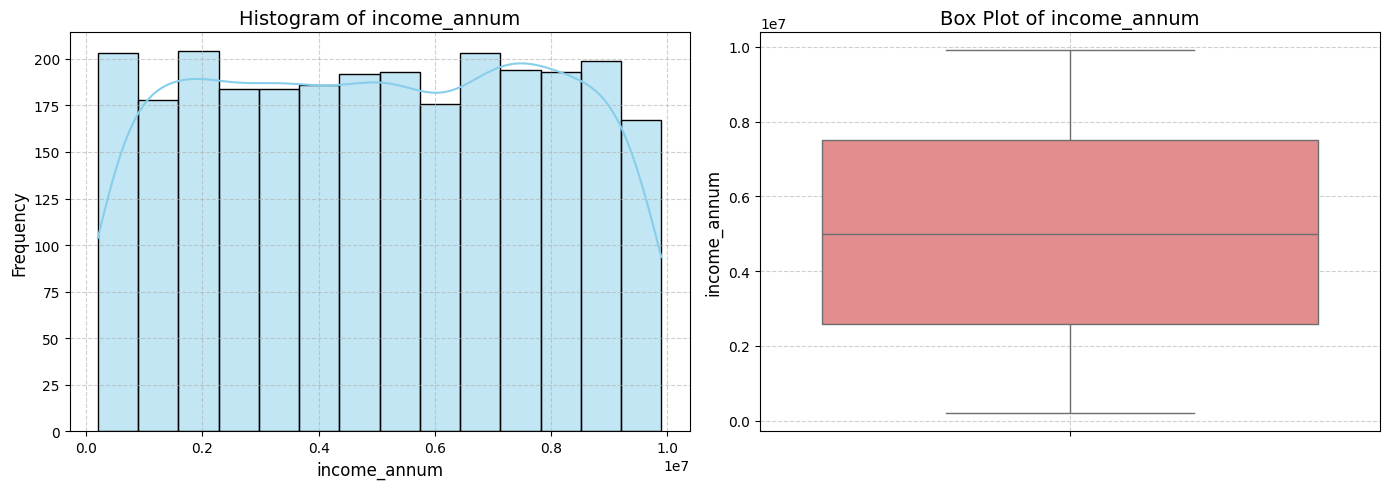

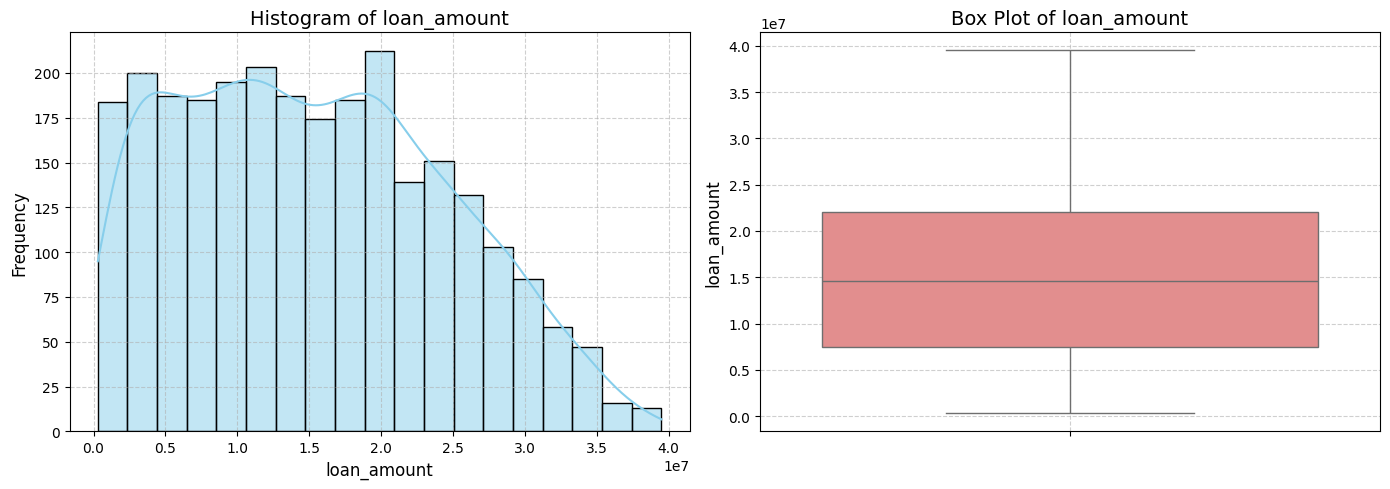

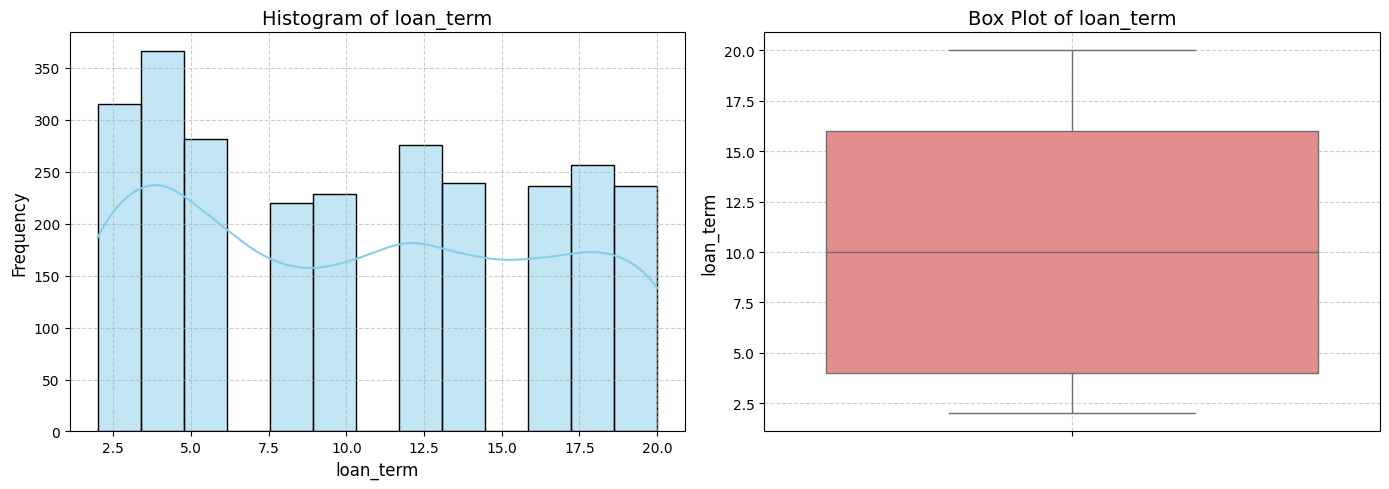

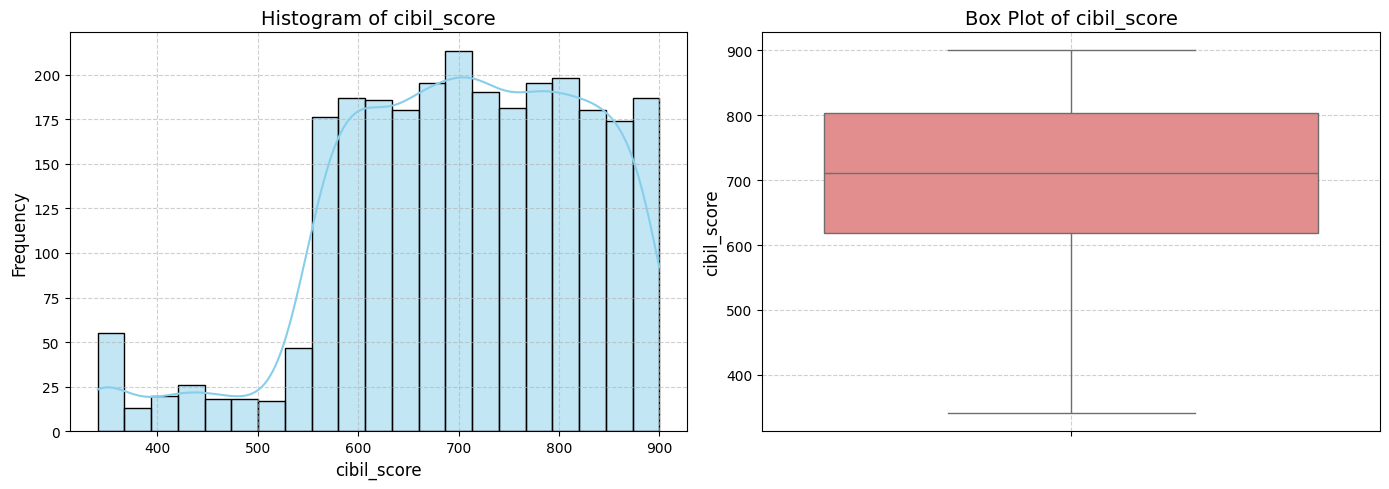

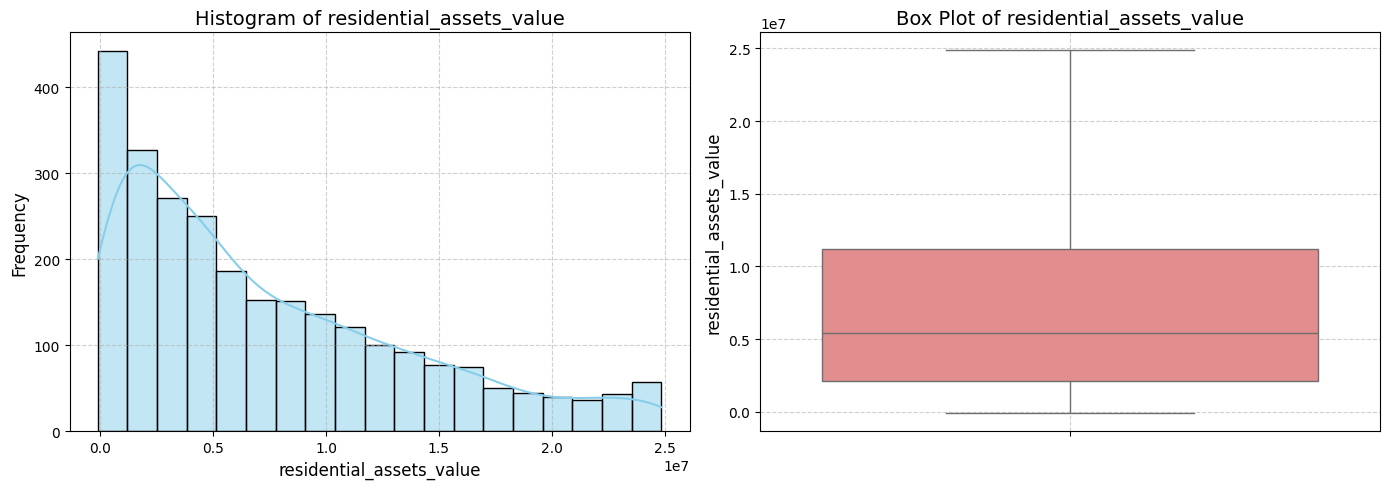

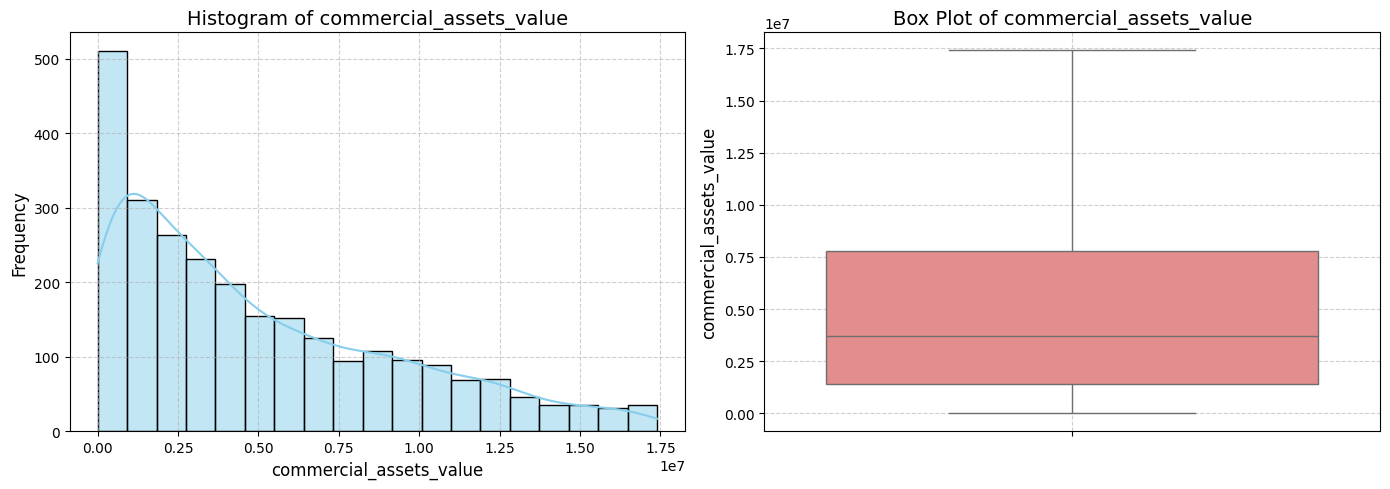

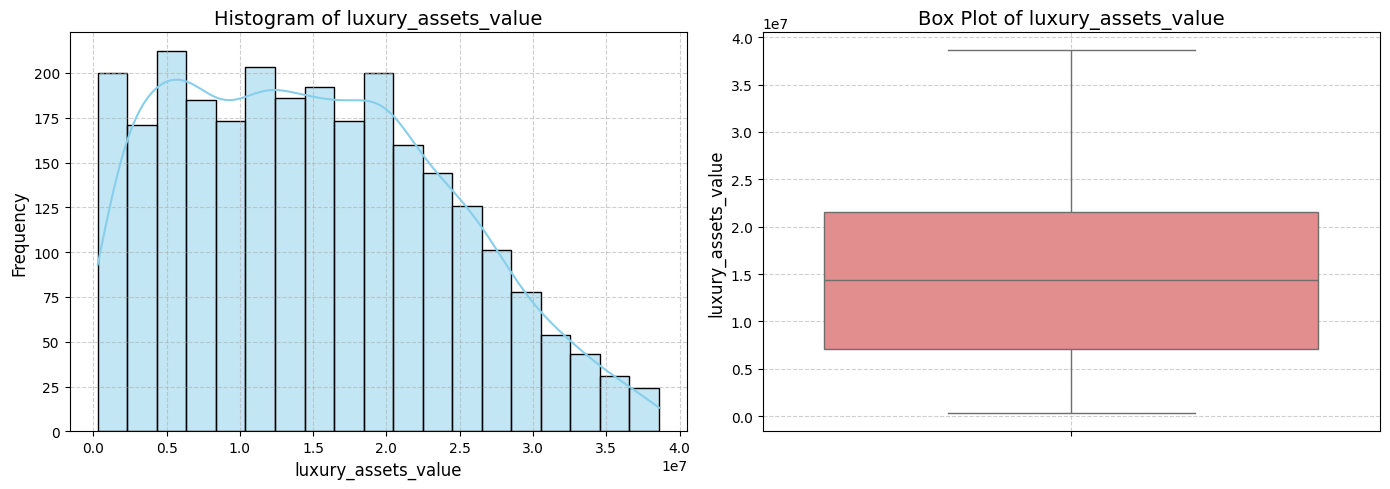

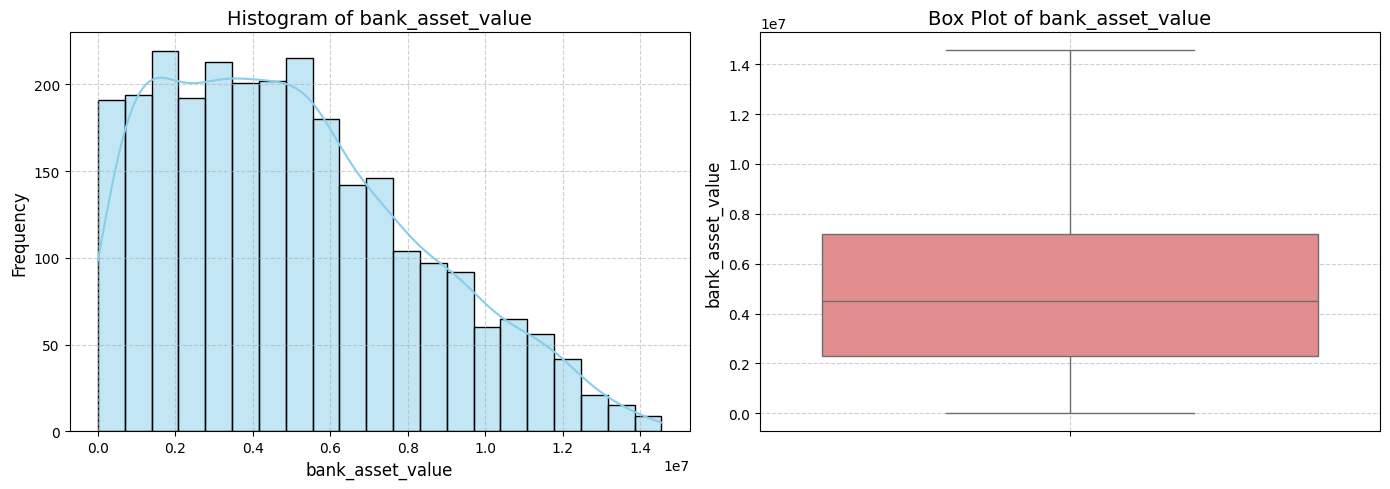

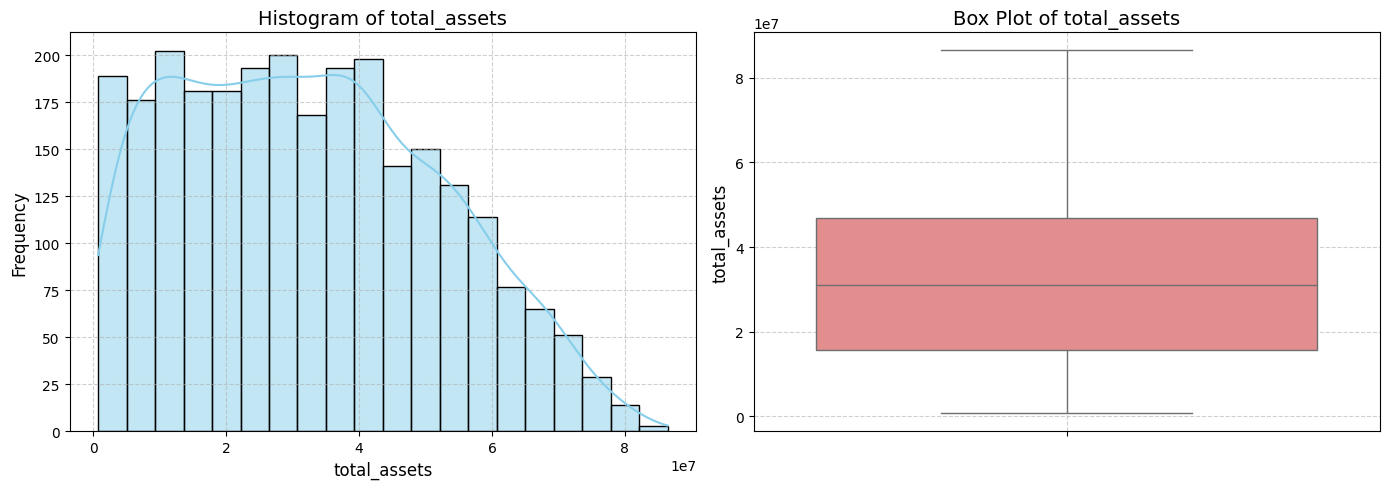

In [ ]:
columns_to_plot = df.columns
hist_color = 'skyblue'
box_color = 'lightcoral'

for col in columns_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(df[col], kde=True, ax=axes[0], color=hist_color)
    axes[0].set_title(f'Histogram of {col}', fontsize=14)
    axes[0].set_xlabel(col, fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    sns.boxplot(y=df[col], ax=axes[1], color=box_color)
    axes[1].set_title(f'Box Plot of {col}', fontsize=14)
    axes[1].set_ylabel(col, fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

**Heatmap to show the corelation between the features**

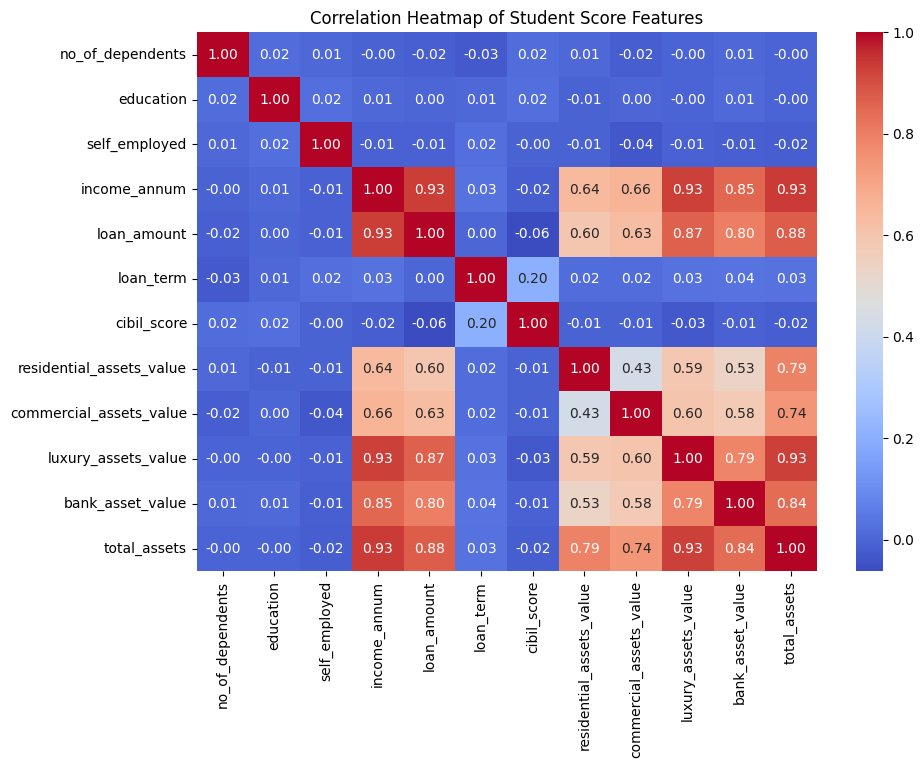

In [ ]:
features = df.select_dtypes(include=['number'])
plt.figure(figsize=(10,7))
sns.heatmap(features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Student Score Features")
plt.show()

**Scatter plot between 2 of the most corelated features**

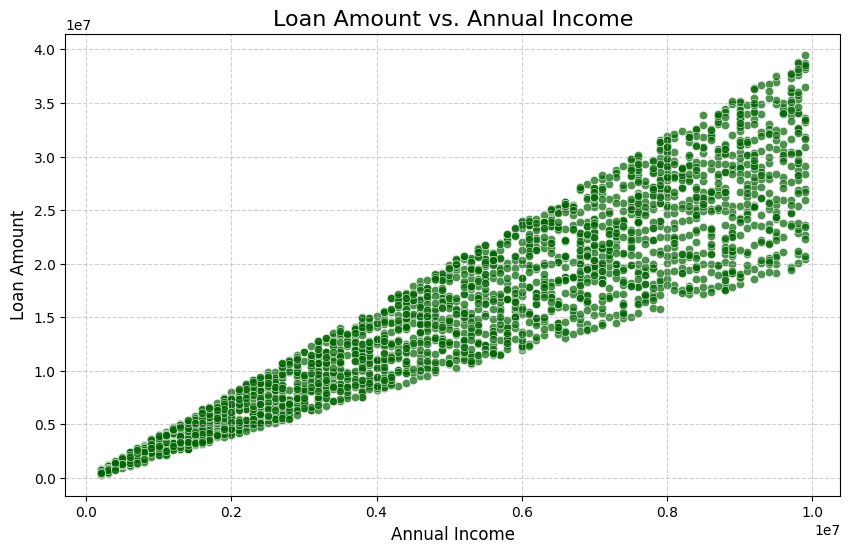

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='income_annum', y='loan_amount', color='darkgreen', alpha=0.7)
plt.title('Loan Amount vs. Annual Income', fontsize=16)
plt.xlabel('Annual Income', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **Splitting The Data**

In [ ]:
X = df.drop(columns=['loan_amount'])
y = df['loan_amount']

# First split: Train and Test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Further split the training data into new training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (1699, 11)
Validation shape: (425, 11)
Test shape: (532, 11)


**Scaling the data**


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Features scaled successfully.
X_train_scaled shape: (1699, 11)
X_val_scaled shape: (425, 11)
X_test_scaled shape: (532, 11)


# **Linear Regression Model**


**Model Fitting**

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

**Training & validation data modelling metrics**

In [ ]:
# Training set predictions
y_train_pred = lr.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae_pct = (train_mae / y_train.mean()) * 100
print("="*70)
print("LINEAR REGRESSION")
print("="*70)
print("Training Set:")
print(f"  MAE: {train_mae:,.0f} ({train_mae_pct:.2f}%)")
print(f"  RMSE: {train_rmse:,.0f}")
print(f"  R²: {train_r2:.4f}")

# Validation set predictions
y_val_pred = lr.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_mae_pct = (val_mae / y_val.mean()) * 100

print("\nValidation Set:")
print(f"  MAE: {val_mae:,.0f} ({val_mae_pct:.2f}%)")
print(f"  RMSE: {val_rmse:,.0f}")
print(f"  R²: {val_r2:.4f}")

LINEAR REGRESSION
Training Set:
  MAE: 2,475,340 (16.27%)
  RMSE: 3,289,713
  R²: 0.8730

Validation Set:
  MAE: 2,648,862 (16.96%)
  RMSE: 3,369,088
  R²: 0.8630


**Testing data modelling metrics**

In [ ]:
# Test set predictions
y_test_pred = lr.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae_pct = (test_mae / y_test.mean()) * 100

print("Test Set:")
print(f"  MAE: {test_mae:,.0f} ({test_mae_pct:.2f}%)")
print(f"  RMSE: {test_rmse:,.0f}")
print(f"  R²: {test_r2:.4f}")

Test Set:
  MAE: 2,505,783 (16.64%)
  RMSE: 3,310,591
  R²: 0.8725


**Comparing training to test and validation**

In [ ]:
mae_diff_val = val_mae_pct - train_mae_pct
r2_diff_val = train_r2 - val_r2

mae_diff_test = test_mae_pct - train_mae_pct
r2_diff_test = train_r2 - test_r2

print("Difference (Validation - Train):")
print(f"  MAE difference: {mae_diff_val:.2f}%")
print(f"  R² difference: {r2_diff_val:.4f}")

print("\nDifference (Test - Train):")
print(f"  MAE difference: {mae_diff_test:.2f}%")
print(f"  R² difference: {r2_diff_test:.4f}")

Difference (Validation - Train):
  MAE difference: 0.69%
  R² difference: 0.0100

Difference (Test - Train):
  MAE difference: 0.37%
  R² difference: 0.0005


**Cross Validation**

In [ ]:
print("CROSS-VALIDATION (5-Fold):")
print("-" * 70)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
mae_scores = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"R² Scores across 5 folds: {[f'{score:.4f}' for score in r2_scores]}")
print(f"  Mean R²: {r2_scores.mean():.4f}")
print(f"  Std R²: {r2_scores.std():.4f}")

print(f"\nMAE Scores across 5 folds: {[f'{score:,.0f}' for score in mae_scores]}")
print(f"  Mean MAE: {mae_scores.mean():,.0f}")
print(f"  Mean MAE%: {(mae_scores.mean()/y.mean())*100:.2f}%")
print(f"  Std MAE: {mae_scores.std():,.0f}")

CROSS-VALIDATION (5-Fold):
----------------------------------------------------------------------
R² Scores across 5 folds: ['0.8724', '0.8749', '0.8643', '0.8687', '0.8683']
  Mean R²: 0.8697
  Std R²: 0.0036

MAE Scores across 5 folds: ['2,452,063', '2,651,078', '2,535,334', '2,534,659', '2,442,045']
  Mean MAE: 2,523,036
  Mean MAE%: 16.55%
  Std MAE: 75,204


**Calculate error as percentage of actual values**

In [ ]:
print(y.describe())
print(f"\nLoan amount range: {y.min()} to {y.max()}")

mae_percentage = (2503990 / y.mean()) * 100
print(f"\nMAE as % of mean loan: {mae_percentage:.2f}%")

count    2.656000e+03
mean     1.524725e+07
std      9.221696e+06
min      3.000000e+05
25%      7.500000e+06
50%      1.460000e+07
75%      2.210000e+07
max      3.950000e+07
Name: loan_amount, dtype: float64

Loan amount range: 300000 to 39500000

MAE as % of mean loan: 16.42%


**Final Summary**

In [ ]:
print("FINAL SUMMARY:")
print("-" * 70)
print(f"Model Performance: Test R² = {test_r2:.4f}, Test MAE = {test_mae_pct:.2f}%")
print(f"Overfitting Risk (Test vs Train): {'LOW' if abs(r2_diff_test) < 0.05 else 'MEDIUM' if abs(r2_diff_test) < 0.1 else 'HIGH'}")
print(f"Stability (Cross-Validation R² Std): {'HIGH' if r2_scores.std() < 0.05 else 'MEDIUM'}")
print("="*70)

FINAL SUMMARY:
----------------------------------------------------------------------
Model Performance: Test R² = 0.8725, Test MAE = 16.64%
Overfitting Risk (Test vs Train): LOW
Stability (Cross-Validation R² Std): HIGH


**Scatter plot of the data with the model**

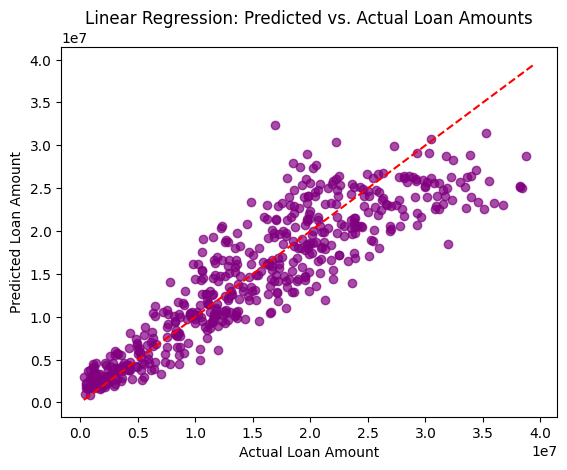

In [50]:
plt.scatter(y_test, y_test_pred, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")  # ideal line
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Linear Regression: Predicted vs. Actual Loan Amounts")
plt.show()

# **KNN Regressor Model**


**Model Fitting**

In [35]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

**Training & validation data modelling metrics**

In [36]:
# Training predictions
y_train_pred = knn.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae_pct = (train_mae / y_train.mean()) * 100

print("Training Set:")
print(f"  MAE: {train_mae:,.0f} ({train_mae_pct:.2f}%)")
print(f"  RMSE: {train_rmse:,.0f}")
print(f"  R²: {train_r2:.4f}")

# Validation predictions
y_val_pred = knn.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_mae_pct = (val_mae / y_val.mean()) * 100

print("\nValidation Set:")
print(f"  MAE: {val_mae:,.0f} ({val_mae_pct:.2f}%)")
print(f"  RMSE: {val_rmse:,.0f}")
print(f"  R²: {val_r2:.4f}")

Training Set:
  MAE: 2,440,035 (16.04%)
  RMSE: 3,341,639
  R²: 0.8689

Validation Set:
  MAE: 3,100,988 (19.86%)
  RMSE: 4,080,840
  R²: 0.7990


**Testing data modelling metrics**

In [40]:
# Test predictions
y_test_pred = knn.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae_pct = (test_mae / y_test.mean()) * 100

print("Test Set:")
print(f"  MAE: {test_mae:,.0f} ({test_mae_pct:.2f}%)")
print(f"  RMSE: {test_rmse:,.0f}")
print(f"  R²: {test_r2:.4f}")

Test Set:
  MAE: 3,031,805 (20.13%)
  RMSE: 4,034,957
  R²: 0.8106


**Comparing training to test and validation**

In [39]:
mae_diff_val = val_mae_pct - train_mae_pct
r2_diff_val = train_r2 - val_r2

mae_diff_test = test_mae_pct - train_mae_pct
r2_diff_test = train_r2 - test_r2

print("Difference (Validation - Train):")
print(f"  MAE difference: {mae_diff_val:.2f}%")
print(f"  R² difference: {r2_diff_val:.4f}")

print("\nDifference (Test - Train):")
print(f"  MAE difference: {mae_diff_test:.2f}%")
print(f"  R² difference: {r2_diff_test:.4f}")

Difference (Validation - Train):
  MAE difference: 3.82%
  R² difference: 0.0700

Difference (Test - Train):
  MAE difference: 4.09%
  R² difference: 0.0584


In [51]:
print("="*70)
if (abs(mae_diff_val) < 3 and abs(r2_diff_val) < 0.05) and \
   (abs(mae_diff_test) < 3 and abs(r2_diff_test) < 0.05):
    print("No significant overfitting")
elif (abs(mae_diff_val) < 5 and abs(r2_diff_val) < 0.1) and \
     (abs(mae_diff_test) < 5 and abs(r2_diff_test) < 0.1):
    print("Minimal overfitting")
else:
    print("Possible overfitting")
print("="*70)

Minimal overfitting


**Cross Validation**

In [43]:
print("CROSS-VALIDATION (5-Fold):")
print("-" * 70)

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor(n_neighbors=5)) # use the same k as above
])

r2_scores_knn = cross_val_score(pipeline_knn, X, y, cv=5, scoring='r2')
mae_scores_knn = -cross_val_score(pipeline_knn, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"R² Scores: {[f'{score:.4f}' for score in r2_scores_knn]}")
print(f"  Mean R²: {r2_scores_knn.mean():.4f} (+/- {r2_scores_knn.std():.4f})")

print(f"\nMAE Scores: {[f'{score:,.0f}' for score in mae_scores_knn]}")
print(f"  Mean MAE: {mae_scores_knn.mean():,.0f}")
print(f"  Mean MAE%: {(mae_scores_knn.mean()/y.mean())*100:.2f}%")
print(f"  Std MAE: {mae_scores_knn.std():,.0f}")

CROSS-VALIDATION (5-Fold):
----------------------------------------------------------------------
R² Scores: ['0.8260', '0.8118', '0.7924', '0.8123', '0.7974']
  Mean R²: 0.8080 (+/- 0.0120)

MAE Scores: ['2,802,857', '3,043,315', '3,078,606', '2,994,237', '3,009,303']
  Mean MAE: 2,985,664
  Mean MAE%: 19.58%
  Std MAE: 95,930


**Comparing with Linear Regression**

In [52]:
print("-" * 70)
lr_test_mae_pct = 16.64
lr_test_r2 = 0.8725

print(f"Linear Regression - Test MAE: {lr_test_mae_pct:.2f}% | R²: {lr_test_r2:.4f}")
print(f"KNN (k=5)         - Test MAE: {test_mae_pct:.2f}% | R²: {test_r2:.4f}")

if test_mae_pct < lr_test_mae_pct:
    print("KNN performs BETTER than Linear Regression!")
elif test_mae_pct < (lr_test_mae_pct + 1.0) and abs(test_r2 - lr_test_r2) < 0.02:
    print("KNN performs similarly to Linear Regression")
else:
    print("Linear Regression performs better")
print("="*70)

----------------------------------------------------------------------
Linear Regression - Test MAE: 16.64% | R²: 0.8725
KNN (k=5)         - Test MAE: 20.13% | R²: 0.8106
Linear Regression performs better


**Scatter plot of the data with the model**

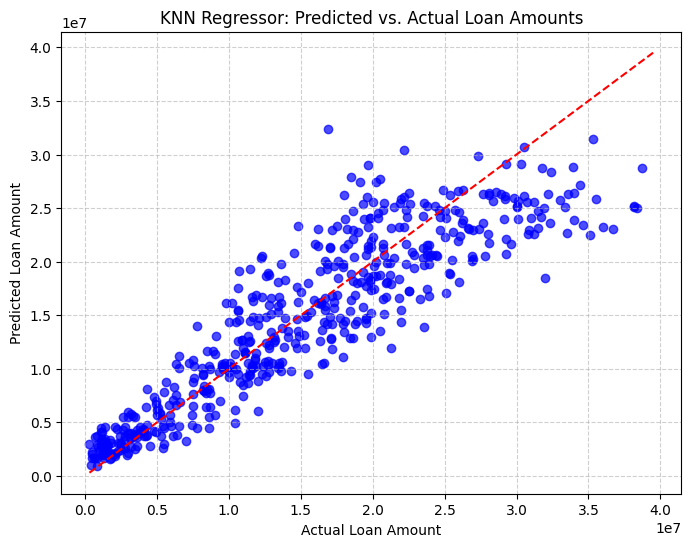

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")  # ideal line
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("KNN Regressor: Predicted vs. Actual Loan Amounts")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()